In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Toy Pareto Front
## Setup
Given an vector of installed renewable capacities (in MW), $\bm{X}$, the cost and material needs (of steel) are given by the followinig equations.

$$
c=\bm{C}^{T}\bm{X}
$$
$$
m_{steel}=\bm{M_{steel}}^{T}\bm{X}
$$

where
* $c$ is the total scalar cost,
* $m_{steel}$ is the total scaler material need of steel, 
* $C$ is the cost matrix
* $M_{steel}$ is the material need matrix

For this toy energy system to be feasible, it must satisfy the following feasibility function.

$$
f(\bm{X})=\text{CF}^{T}\bm{X} \ge D
$$
where
* $\text{CF}$ is the vector of capacity factors
* $D$ is the average yearly demand in MW

## Defining vectors
This toy example will consider an energy system comprised of only wind and solar PV generation. Therefore, $\bm{X}$ is defined as
$$
\bm{X}=\begin{pmatrix} x_{wind} \\ x_{solar} \end{pmatrix}
$$
The cost is the economic cost per MW of installed capacity, which is USD 1.50/MW for (onshore) wind and USD 1.66/MW for for solar PV (in the USA in 2022)<sup>1</sup>. Therefore the cost vector is
$$
\bm{C} = \begin{pmatrix} c_{wind} \\ c_{solar} \end{pmatrix} = \begin{pmatrix} 1.50 \\ 1.66 \end{pmatrix}
$$
The material steel requirements are 120-180 tons/MW capacity for wind and 35-45 tons/MW for solar (global in 2022)<sup>2</sup>. Therefore, the material requirements vector is
$$
\bm{M_{steel}} = \begin{pmatrix} m_{steel, wind} \\ m_{steel, solar} \end{pmatrix} = \begin{pmatrix} 150 \\ 40 \end{pmatrix}
$$
The capacity factors are 0.3-0.5 for wind and 0.15-0.2 for solar<sup>3</sup>. Therefore, the capacity factor vector is
$$
\text{CF} = \begin{pmatrix} \text{CF}_{wind} \\ \text{CF}_{solar} \end{pmatrix} = \begin{pmatrix} 0.4 \\ 0.175 \end{pmatrix}
$$
The yearly European electricity consumption is approximately 3000 TWh, which is an average of 350 GW. Therefore, the demand (in MW) is
$$
D = 350,000
$$

In [2]:
c_w = 1.5
c_s = 1.66
m_w = 150
m_s = 40
cf_w = 0.4
cf_s = 0.175
D = 350000

class Point:
    """
    Class for each wind, solar data point input and their respective output quantities.
    """

    # define constants as class-level attributes
    C = np.array([[c_w], [c_s]])  # cost vector
    M_steel = np.array([[m_w], [m_s]])  # material need vector
    A = np.array([[c_w, c_s], [m_w, m_s]]) # transformation matrix

    CF = np.array([[cf_w], [cf_s]])  # capacity factor vector
    D = D

    def __init__(self, x_wind, x_solar):
        self.x_wind = x_wind
        self.x_solar = x_solar

    @property
    def X(self):
        # Vector representing the two input variables of each sample
        return np.array([[self.x_wind], [self.x_solar]])

    @property
    def is_feasible(self):
        return (Point.CF.T @ self.X >= Point.D).item()
    
    @property
    def cost(self):
        return (Point.C.T @ self.X).item()

    @property
    def material_needs_steel(self):
        return (Point.M_steel.T @ self.X).item()
    
    @property
    def Y(self):
        # Vector representing the two output variables of each sample (cost, material needs)
        return Point.A @ self.X


## Sampling from the input space

Using a Monte Carlo technique, $\bm{X}$ can be sampled from a uniform distribution between arbitrary bounds for the capacites of wind and solar. Here we will choose within 50% of the maximum for wind and solar.

By rearranging the feasibility condition, we can find the maximum capacities of wind and solar, which will be used to set the bounds for sampling.
$$
x_{wind}(x_{solar} = 0) = \frac{D}{\text{CF}_{solar}}, \quad
x_{solar}(x_{wind} = 0) = \frac{D}{\text{CF}_{wind}}
$$

In [3]:
num_samples = 20000
samples = []
x_wind_max = Point.D / Point.CF[0, 0]
x_solar_max = Point.D / Point.CF[1, 0]
x_wind_range = (0, x_wind_max * 1.8)
x_solar_range = (0, x_solar_max * 1.8)

for _ in range(num_samples):
    samples.append(Point(np.random.uniform(*x_wind_range), np.random.uniform(*x_solar_range)))

## Extract input and output variables for each sample

In [4]:
def convert_points_to_dataframe(samples, linalg=False):
    """Converts a list of Sample objects into a pandas DataFrame."""
    # input variables
    x_wind_values = [sample.x_wind for sample in samples]
    x_solar_values = [sample.x_solar for sample in samples]

    # output variables
    costs = [sample.cost for sample in samples]
    material_needs = [sample.material_needs_steel for sample in samples]
    feasibility = [sample.is_feasible for sample in samples]

    data = pd.DataFrame({
        'Wind Capacity (MW)': x_wind_values,
        'Solar Capacity (MW)': x_solar_values,
        'Cost (USD)': costs,
        'Material Needs (tons)': material_needs,
        'Feasibility': feasibility,
    })
    
    return data

data = convert_points_to_dataframe(samples)

## Plot input space

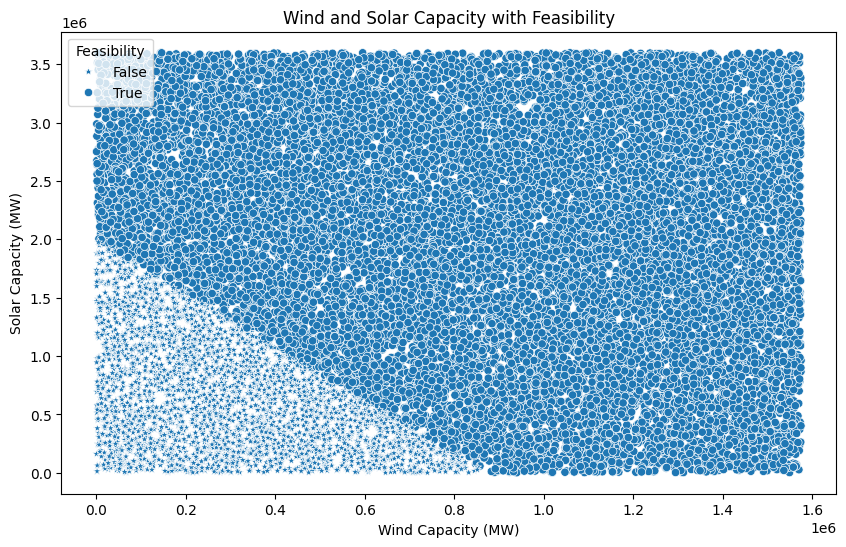

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Wind Capacity (MW)', y='Solar Capacity (MW)', style='Feasibility', markers=['*', 'o'])
plt.title('Wind and Solar Capacity with Feasibility')
plt.show()

## Plotting the Pareto Front of materials requirements against cost

We can plot the cost, $c$, and material requirements of steel, $m_{steel}$, for each feasible point in the input space.

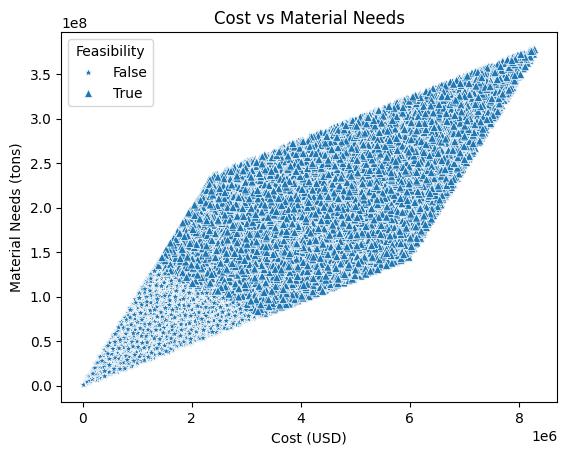

In [6]:
sns.scatterplot(x='Cost (USD)', y='Material Needs (tons)', style='Feasibility', markers=['*', '^'], data=data)
plt.title('Cost vs Material Needs')
plt.show()

## Linear algebra interpretation

$$
c = \bm{C}^{T}\bm{X},\; m = \bm{M}^{T}\bm{X}
\\[10pt]
\bm{Y} = \underbrace{\begin{pmatrix} c_{wind} && c_{solar} \\ m_{steel, wind} && m_{steel, solar} \end{pmatrix}}_{A} \bm{X}
$$

Where $\bm{Y}$ is the output vector, $\bm{Y} =  \begin{pmatrix} c \\ m \end{pmatrix} \in \mathcal{Y}$, where $\mathcal{Y} \subseteq \mathbb{R}^{2} $ is the set of the output space.

This can be visualised as a linear transformation according to matrix $A = \begin{pmatrix} 1.50 && 1.66 \\ 40 && 150 \end{pmatrix}$. This means the input space is linearly mapped to an output space according to the new basis vectors below:

$$
\bm{\hat{i}'} = \begin{bmatrix} 1.5 \\ 40 \end{bmatrix}, \;
\bm{\hat{j}'} = \begin{bmatrix} 1.66 \\ 150 \end{bmatrix}
$$

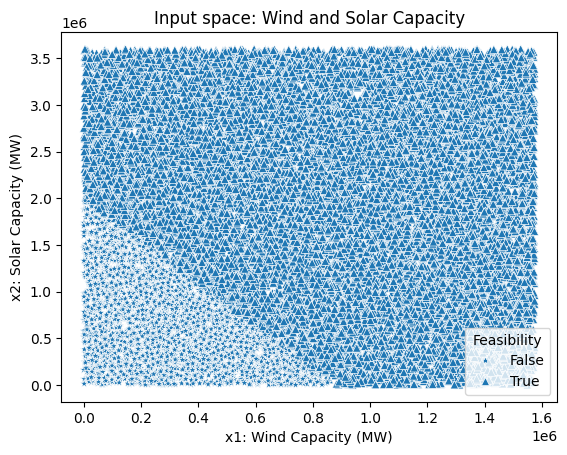

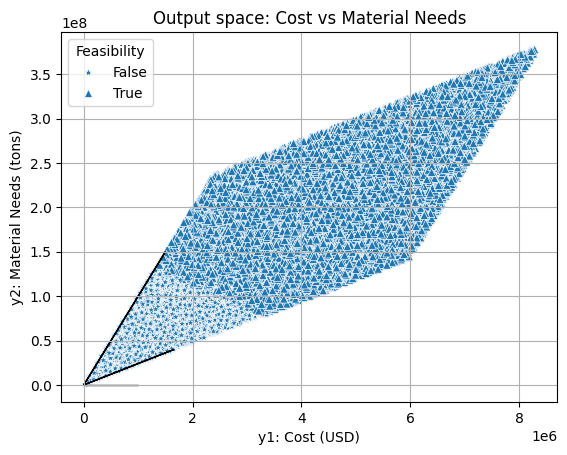

In [7]:
def convert_points_to_dataframe_linalg(samples):
    """Converts a list of Sample objects into a pandas DataFrame. Now using the linear algebra approach."""

    # input variables
    x_wind_values = [sample.X[0, 0] for sample in samples]
    x_solar_values = [sample.X[1, 0] for sample in samples]

    # output variables
    costs = [sample.Y[0, 0] for sample in samples]
    material_needs = [sample.Y[1, 0] for sample in samples]
    feasibility = [sample.is_feasible for sample in samples]

    data = pd.DataFrame({
        'x1: Wind Capacity (MW)': x_wind_values,
        'x2: Solar Capacity (MW)': x_solar_values,
        'y1: Cost (USD)': costs,
        'y2: Material Needs (tons)': material_needs,
        'Feasibility': feasibility,
    })

    data.set_index(["x1: Wind Capacity (MW)", "x2: Solar Capacity (MW)"], inplace=True)
    return data

data_linalg = convert_points_to_dataframe_linalg(samples)

# calculate the new basis vectors
# basis vectors
i_hat = np.array([[1], [0]])
j_hat = np.array([[0], [1]])

# transformed basis vectors
i_hat_prime = np.array([[c_w], [m_w]])
j_hat_prime = np.array([[c_s], [m_s]])

vectors = [i_hat, j_hat, i_hat_prime, j_hat_prime]

# plot input space
ax1 = sns.scatterplot(data=data_linalg, x='x1: Wind Capacity (MW)', y='x2: Solar Capacity (MW)', style='Feasibility', markers=['*', '^'])
plt.title('Input space: Wind and Solar Capacity')
plt.show()

# plot output space with transformed basis vectors
ax2 = sns.scatterplot(x='y1: Cost (USD)', y='y2: Material Needs (tons)', style='Feasibility', markers=['*', '^'], data=data_linalg)
plt.title('Output space: Cost vs Material Needs')

# Plot each vector
for v in vectors:
    v = v * 1e6 # scale vectors up so they're visible
    ax2.arrow(0, 0, v[0, 0], v[1, 0])

ax2.grid(True)
plt.show()

Awesome! As we can see, this entire example can be condensed into a single linear transormation (aka. matrix multiplication), according to the matrix $A$. This can be visualised by transforming the 2-D input space of $(x_{wind}, x_{solar})$ into the 2-D output space of $(c, m)$, according to the new basis vectors, $\bm{\hat{i}'}$ and $\bm{\hat{j}'}$.

## Optimising using linear programming

Scipy's linprog function, `scipy.optimize.linprog`, requires LP problems of the following form.

$$
\begin{align}
\text{Find a vector} \quad   &\bm{x} \\
\text{that minimizes} \quad   &\bm{c}^{T}\bm{x} \\
\text{subject to} \quad   &A_{ub}\bm{x}\leq\bm{b_{ub}} \\
\text{and} \quad  \bm{l} \leq &\bm{x} \leq \bm{u} \\
\end{align}
$$

Our system can be minimally described by the following
$$
\bm{y} = A\bm{x} \\[10pt]
\bm{CF}^{T}\bm{x} \ge D
$$
where
$$
\bm{x} = \begin{bmatrix} x_w \\ x_s \end{bmatrix}, \quad
\bm{y} = \begin{bmatrix} c \\ m \end{bmatrix}, \quad
A = \begin{pmatrix} c_w && c_s \\ m_w && m_s \end{pmatrix}, \quad
\bm{CF} = \begin{bmatrix} CF_w \\ CF_s \end{bmatrix}
$$

We have not yet defined an objective function, but we will likely want to minimise some linear combination of the cost, $c$, and material requirement, $m$. We can define this with the vector, $ \bm{c_{y}} $, as follows.
$$
\text{Minimize} \quad \bm{c_{y}}^{T}\bm{y}
$$

Converting our problem into the standard accepted by Scipy results in the following.
$$
\begin{align}
\text{Find a vector} \quad & \bm{x} \\
\text{that minimises} \quad & \underbrace{\bm{c_{y}}^{T}A}_{\bm{c^{T}}}\bm{x} \\
\text{subject to} \quad & \bm{CF}^{T}\bm{x} \ge D \implies \underbrace{-\bm{CF}^{T}}_{A_{ub}} \bm{x} \le \underbrace{-D}_{\bm{b_{ub}}}\\
\text{and} \quad & \underbrace{\bm{0}}_{\bm{l}} \le \bm{x}
\end{align}

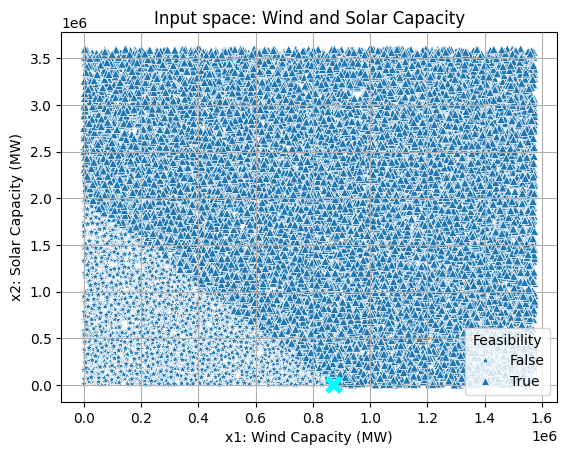

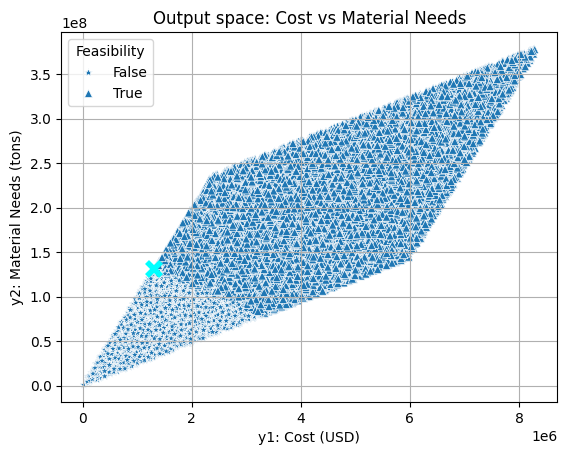

In [8]:
from scipy.optimize import linprog
from mpl_toolkits.mplot3d import Axes3D

# Define objective function via c
coef_cost = 50
coef_material = 1
c_y = np.array([[coef_cost], [coef_material]])  # Coefficients for cost and material in the objective function
c = c_y.T @ Point.A

# Define constraints
A_ub = - Point.CF.T
b_ub = - Point.D

# Bounds for x
x_bounds = (0, None)

# Solve the linear programming problem
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds)

# Calculate the optimum point using LP
if result.success:
    x_opt = result.x
else:
    print("Optimization failed:", result.message)


# Visualise the optimum point
# plot input space
ax_2d_x = sns.scatterplot(data=data_linalg, x='x1: Wind Capacity (MW)', y='x2: Solar Capacity (MW)', style='Feasibility', markers=['*', '^'])
ax_2d_x.plot(x_opt[0], x_opt[1], marker='x', color='cyan', markersize=10, mew=4)
ax_2d_x.grid(True)
plt.title('Input space: Wind and Solar Capacity')
plt.show()

# plot output space
y_opt = Point.A @ x_opt
ax_2d_y = sns.scatterplot(data=data_linalg, x='y1: Cost (USD)', y='y2: Material Needs (tons)', style='Feasibility', markers=['*', '^'])
ax_2d_y.plot(y_opt[0], y_opt[1], marker='x', color='cyan', markersize=10, mew=4)
ax_2d_y.grid(True)
plt.title('Output space: Cost vs Material Needs')
plt.show()

# Show that having more datapoints (as with a SM) leads to richer policy-relevant conclusions

Now we want to show that having more datapoints (as you would when using a surrogate model) can lead to richer policy insights. We will introduce a "self-sufficiency" output, so now our outputs are:
1. economic cost
1. material cost (indicated by steel requirements)
1. self-suffiency cost

How should we model self-sufficiency? Use the trade-off from Tim's paper:
$$
capacity_{scale=regional} = capacity_{scale=continental} \times 1.4
$$

In this model, we will model self-sufficiency as an input, where if a system is self-sufficient, it causes a penalty the threshold for feasibility to be 1.4 times. Therefore, if an energy system includes self-sufficiency, then the constraint for feasibility is given by the following equation.

$$
\bm{CF}^{T} \ge D \times 1.4
$$

Note that in a proper energy system model, self-sufficiency would be an outcome of the modelling. 

1. look at the material needs of the toy model and compare 2 cost minimal scenarios
1. see how this explains the relationship between autarky and materials
1. then, make a hist of options along the material dimension for both autarky and non-autarky
1. (hopefully) show that having more datapoints results in a much richer understanding of the relationship between x and y
1. then, try and incorporate cost, i.e., limit to w/i 10% of the cost optimum

In [9]:
class PointSS:
    """
    Class for each wind, solar data point input and their respective output quantities. 
    Now include self-sufficiency modelled as an input which imposes a penalty on the capacity factor.
    We will investigate self-sufficiency as if it were an output.
    """

    # define constants as class-level attributes
    C = np.array([[c_w], [c_s]])  # cost vector
    M_steel = np.array([[m_w], [m_s]])  # material need vector
    A = np.array([[c_w, c_s], [m_w, m_s]]) # transformation matrix
    CF = np.array([[cf_w], [cf_s]])  # capacity factor vector
    D = D
    self_sufficiency_penalty = 1.4

    def __init__(self, x_wind: float, x_solar: float, self_sufficiency: bool):
        self.x_wind = x_wind
        self.x_solar = x_solar
        self.self_sufficiency = self_sufficiency # True if we want to emulate self-sufficiency in this sample

    def __repr__(self) -> str:
        return f"PointSS(x_wind={self.x_wind}, x_solar={self.x_solar}, self_sufficiency={self.self_sufficiency}):\n Cost: {self.cost}\n  Material Needs: {self.material_needs_steel}\n  Feasible: {self.is_feasible}"

    @property
    def X(self):
        # Vector representing the two input variables of each sample
        return np.array([[self.x_wind], [self.x_solar]])

    @property
    def is_feasible(self):
        if self.self_sufficiency:
            return (PointSS.CF.T @ self.X >= PointSS.D * PointSS.self_sufficiency_penalty).item()
        else:
            return (PointSS.CF.T @ self.X >= PointSS.D).item()

    @property
    def cost(self):
        if self.self_sufficiency:
            return (PointSS.C.T @ self.X).item()
        return (PointSS.C.T @ self.X).item()

    @property
    def material_needs_steel(self):
        return (PointSS.M_steel.T @ self.X).item()
    
    @property
    def Y(self):
        # Vector representing the two output variables of each sample (cost, material needs)
        return PointSS.A @ self.X


def convert_points_to_dataframe_ss(samples):
    """Converts a list of Point objects into a pandas DataFrame using the linear algebra approach. Now includes self-sufficiency as a variable."""
    # input variables
    x_wind_values = [sample.X[0, 0] for sample in samples]
    x_solar_values = [sample.X[1, 0] for sample in samples]

    # output variables
    costs = [sample.Y[0, 0] for sample in samples]
    material_needs = [sample.Y[1, 0] for sample in samples]
    feasibility = [sample.is_feasible for sample in samples]
    self_sufficiency = [sample.self_sufficiency for sample in samples]

    data = pd.DataFrame({
        'Wind Capacity (MW)': x_wind_values,
        'Solar Capacity (MW)': x_solar_values,
        'Cost (USD)': costs,
        'Material Needs (tons)': material_needs,
        'Feasibility': feasibility,
        'Self-Sufficiency': self_sufficiency,
    })

    return data

## Visualise points including self-sufficiency

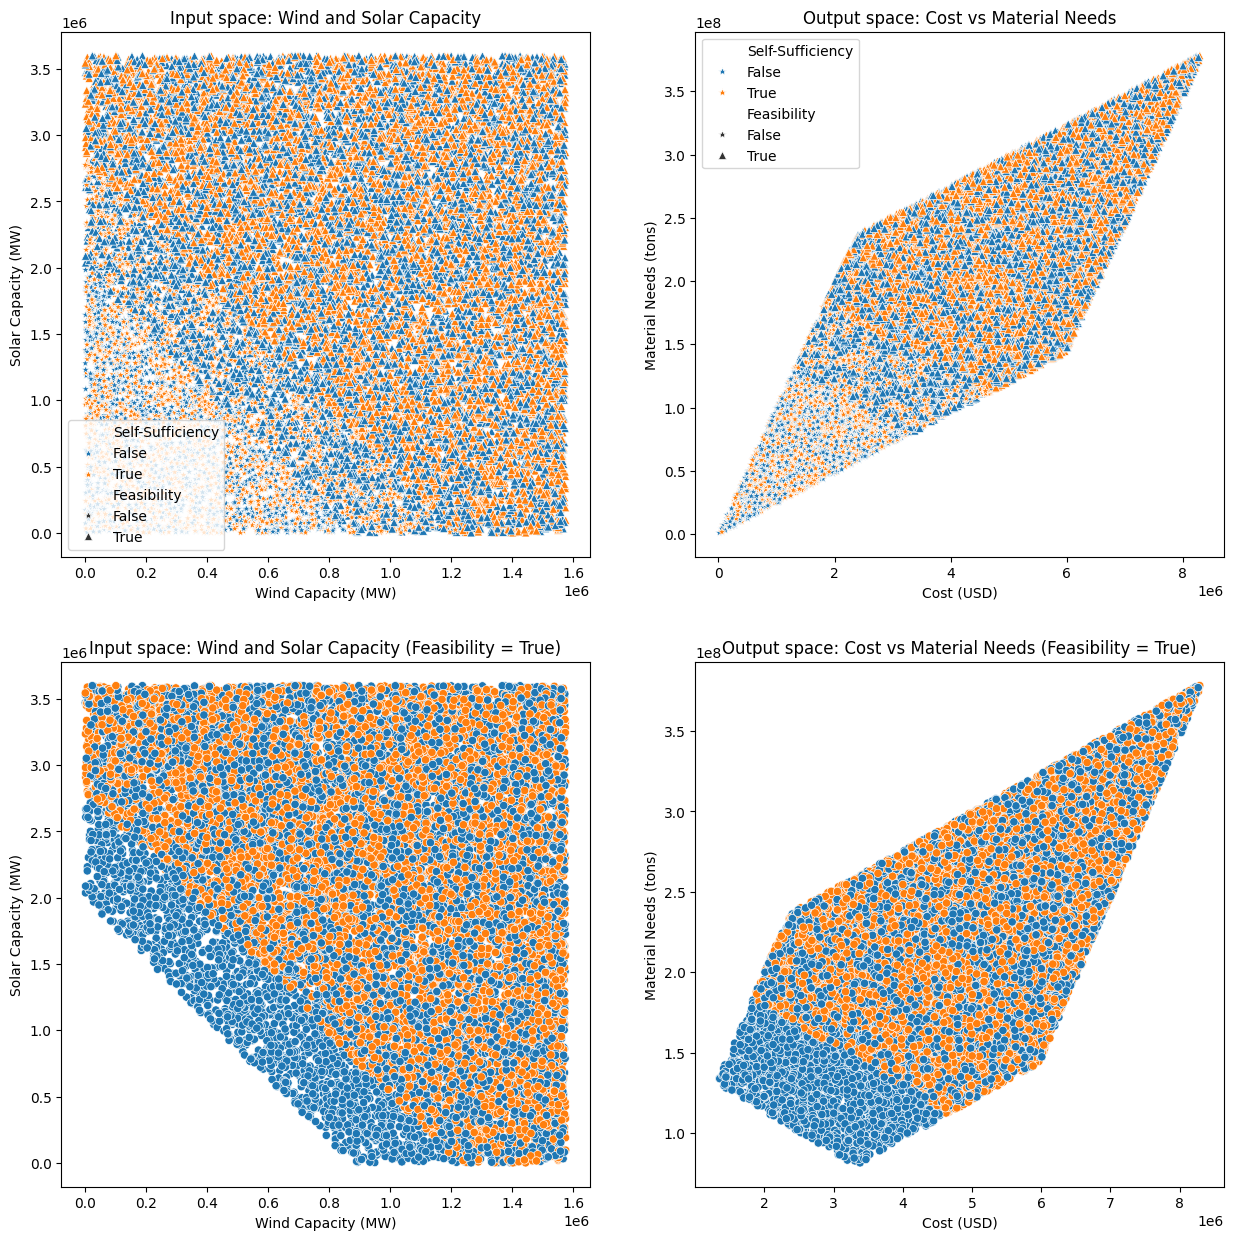

In [10]:
# Generate samples from the PointSS class
samples_ss = []
for _ in range(num_samples):
    samples_ss.append(PointSS(
        x_wind=np.random.uniform(*x_wind_range), 
        x_solar=np.random.uniform(*x_solar_range), 
        self_sufficiency=np.random.choice([True, False])
    ))

data_ss = convert_points_to_dataframe_ss(samples_ss)

# plot input and output space including feasibility and not including feasibility for clarity
# make a grid of 2x2 plots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

ax_2d_x_ss = sns.scatterplot(data=data_ss, x='Wind Capacity (MW)', y='Solar Capacity (MW)', style='Feasibility', markers=['*', '^'], hue='Self-Sufficiency', ax=axs[0, 0])
ax_2d_x_ss.set_title('Input space: Wind and Solar Capacity')

ax_2d_y_ss = sns.scatterplot(data=data_ss, x='Cost (USD)', y='Material Needs (tons)', style='Feasibility', markers=['*', '^'], hue='Self-Sufficiency', ax=axs[0, 1])
ax_2d_y_ss.set_title('Output space: Cost vs Material Needs')

ax_2d_x_ss_no_feas = sns.scatterplot(data=data_ss.loc[data_ss['Feasibility'] == True], x='Wind Capacity (MW)', y='Solar Capacity (MW)', hue='Self-Sufficiency', ax=axs[1, 0])
ax_2d_x_ss_no_feas.set_title('Input space: Wind and Solar Capacity (Feasibility = True)')
ax_2d_x_ss_no_feas.legend_.remove()

ax_2d_y_ss_no_feas = sns.scatterplot(data=data_ss.loc[data_ss['Feasibility'] == True], x='Cost (USD)', y='Material Needs (tons)', hue='Self-Sufficiency', ax=axs[1, 1])
ax_2d_y_ss_no_feas.set_title('Output space: Cost vs Material Needs (Feasibility = True)')
ax_2d_y_ss_no_feas.legend_.remove()

plt.show()

Wow. Waddyaknow - there's a section for which only the non-self-sufficient energy systems work!

## Evaluate 2 cost-minimal samples

Here we need to return to the linear algebra and LP stuff, but augment to include a concept of self-sufficiency.

Our system can be minimally described by the following.
$$
\bm{y} = A\bm{x} \\[10pt]
\bm{CF}^{T}\bm{x} \ge D \times 1.4
$$
where
$$
\bm{x} = \begin{bmatrix} x_w \\ x_s \end{bmatrix}, \quad
\bm{y} = \begin{bmatrix} c \\ m \end{bmatrix}, \quad
A = \begin{pmatrix} c_w && c_s \\ m_w && m_s \end{pmatrix}, \quad
\bm{CF} = \begin{bmatrix} CF_w \\ CF_s \end{bmatrix}
$$

Minimise some linear combination of the cost, $c$, and material requirement, $m$, using the vector, $ \bm{c_{y}} $, as follows.
$$
\text{Minimize} \quad \bm{c_{y}}^{T}\bm{y}
$$

Converting our problem into the standard accepted by Scipy results in the following.
$$
\begin{align}
\text{Find a vector} \quad & \bm{x} \\
\text{that minimises} \quad & \underbrace{\bm{c_{y}}^{T}A}_{\bm{c^{T}}}\bm{x} \\
\text{subject to} \quad & \bm{CF}^{T}\bm{x} \ge D \implies \underbrace{-\bm{CF}^{T}}_{A_{ub}} \bm{x} \le \underbrace{-D}_{\bm{b_{ub}}}\\
\text{and} \quad & \underbrace{\bm{0}}_{\bm{l}} \le \bm{x}
\end{align}

/var/folders/cd/3symzw7d0833vd8qj4shbrl80000gp/T/ipykernel_32253/2150164332.py:33: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  ax_2d_x_ss = sns.scatterplot(data=data_ss.loc[data_ss['Feasibility']==True], x='Wind Capacity (MW)', y='Solar Capacity (MW)', style='Feasibility', markers=['*', '^'], hue='Self-Sufficiency')


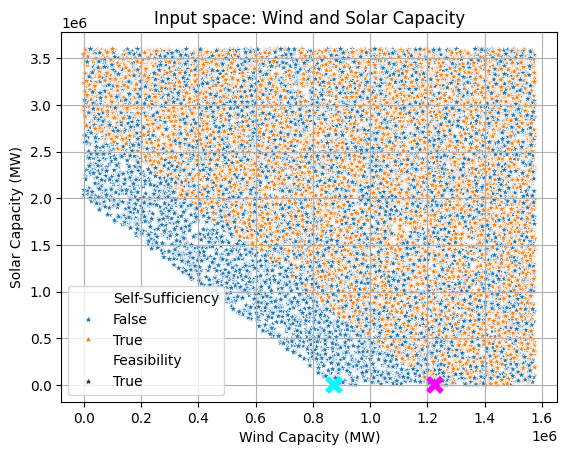

/var/folders/cd/3symzw7d0833vd8qj4shbrl80000gp/T/ipykernel_32253/2150164332.py:43: UserWarning: The markers list has more values (2) than needed (1), which may not be intended.
  ax_2d_y_ss = sns.scatterplot(data=data_ss.loc[data_ss['Feasibility']==True], x='Cost (USD)', y='Material Needs (tons)', style='Feasibility', markers=['*', '^'], hue='Self-Sufficiency')


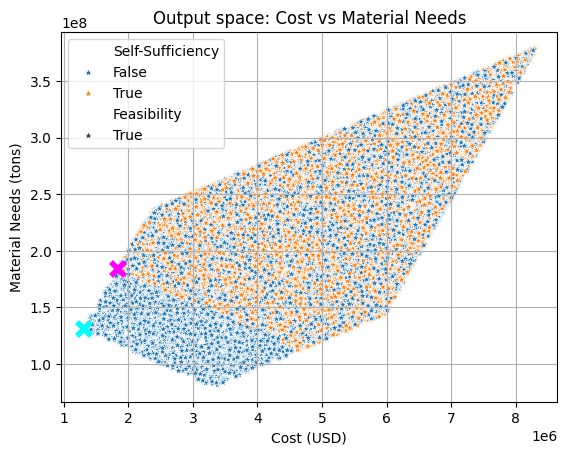

In [11]:
def find_optimum_point(coef_cost: float, coef_material: float, self_sufficiency: bool) -> PointSS:
    # Define objective function via c
    c_y = np.array([[coef_cost], [coef_material]])  # Coefficients for cost and material in the objective function
    c = c_y.T @ PointSS.A

    # Define constraints
    A_ub = - PointSS.CF.T
    if self_sufficiency:
        b_ub = - PointSS.D * PointSS.self_sufficiency_penalty
    else:
        b_ub = - PointSS.D

    # Bounds for x
    x_bounds = (0, None)

    # Solve the linear programming problem
    result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds)

    # Calculate the optimum point using LP
    if result.success:
        x_opt = result.x
    else:
        print("Optimization failed:", result.message)

    return PointSS(x_opt[0], x_opt[1], self_sufficiency)

# find the optimum point for each self-sufficiency scenario
sample_non_ss = find_optimum_point(coef_cost, coef_material, self_sufficiency=False)
sample_ss = find_optimum_point(coef_cost, coef_material, self_sufficiency=True)

# visualise the optimum points
# plot input space
ax_2d_x_ss = sns.scatterplot(data=data_ss.loc[data_ss['Feasibility']==True], x='Wind Capacity (MW)', y='Solar Capacity (MW)', style='Feasibility', markers=['*', '^'], hue='Self-Sufficiency')
ax_2d_x_ss.plot(sample_non_ss.x_wind, sample_non_ss.x_solar, marker='x', color='cyan', markersize=10, mew=4)
ax_2d_x_ss.plot(sample_ss.x_wind, sample_ss.x_solar, marker='x', color='magenta', markersize=10, mew=4)
ax_2d_x_ss.grid(True)
plt.title('Input space: Wind and Solar Capacity')
plt.show()

# plot output space
y_opt_non_ss = sample_non_ss.Y
y_opt_ss = sample_ss.Y
ax_2d_y_ss = sns.scatterplot(data=data_ss.loc[data_ss['Feasibility']==True], x='Cost (USD)', y='Material Needs (tons)', style='Feasibility', markers=['*', '^'], hue='Self-Sufficiency')
ax_2d_y_ss.plot(y_opt_non_ss[0], y_opt_non_ss[1], marker='x', color='cyan', markersize=10, mew=4)
ax_2d_y_ss.plot(y_opt_ss[0], y_opt_ss[1], marker='x', color='magenta', markersize=10, mew=4)
ax_2d_y_ss.grid(True)
plt.title('Output space: Cost vs Material Needs')
plt.show()

Wind Capacity (MW)  Solar Capacity (MW)  Cost (USD)  Material Needs (tons)  \
0            875000.0                  0.0   1312500.0            131250000.0   
1           1225000.0                  0.0   1837500.0            183750000.0   

   Self-Sufficiency  
0             False  
1              True

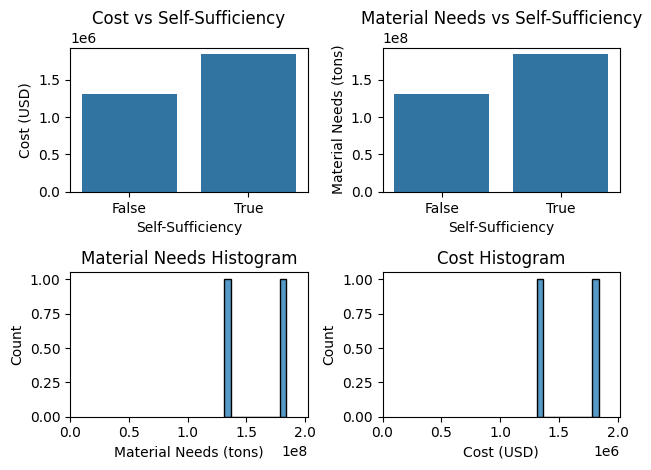

In [12]:
# make a database of the two optimum points
data_ss_min = pd.DataFrame({
    'Wind Capacity (MW)': [sample_non_ss.x_wind, sample_ss.x_wind],
    'Solar Capacity (MW)': [sample_non_ss.x_solar, sample_ss.x_solar],
    'Cost (USD)': [sample_non_ss.cost, sample_ss.cost],
    'Material Needs (tons)': [sample_non_ss.material_needs_steel, sample_ss.material_needs_steel],
    'Self-Sufficiency': [False, True],
})

display(data_ss_min)

fig, ax = plt.subplots(2, 2)

# plot the relationship between self-sufficiency and cost
ax_cost_min = sns.barplot(data=data_ss_min, x='Self-Sufficiency', y='Cost (USD)', ax=ax[0, 0])
ax_cost_min.set_title('Cost vs Self-Sufficiency')

# plot the relationship between self-sufficiency and material needs
ax_material_min = sns.barplot(data=data_ss_min, x='Self-Sufficiency', y='Material Needs (tons)', ax=ax[0, 1])
ax_material_min.set_title('Material Needs vs Self-Sufficiency')

# plot a histogram of the material needs of the two optimum points
ax_hist = sns.histplot(data=data_ss_min, x='Material Needs (tons)', bins=10, ax=ax[1, 0])
ax_hist.set_xlim(0, data_ss_min['Material Needs (tons)'].max()*1.1)
ax_hist.set_title('Material Needs Histogram')

# plot a histogram of the cost of the two optimum points
ax_hist = sns.histplot(data=data_ss_min, x='Cost (USD)', bins=10, ax=ax[1, 1])
ax_hist.set_xlim(0, data_ss_min['Cost (USD)'].max()*1.1)
ax_hist.set_title('Cost Histogram')

plt.tight_layout()
plt.show()

## Evaluate many samples (not just cost-minimal)


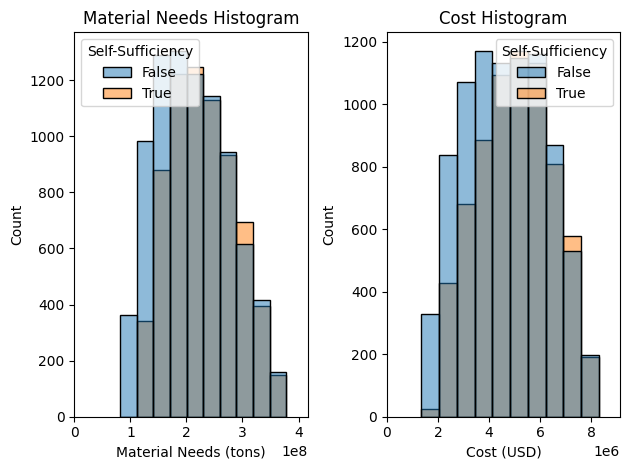

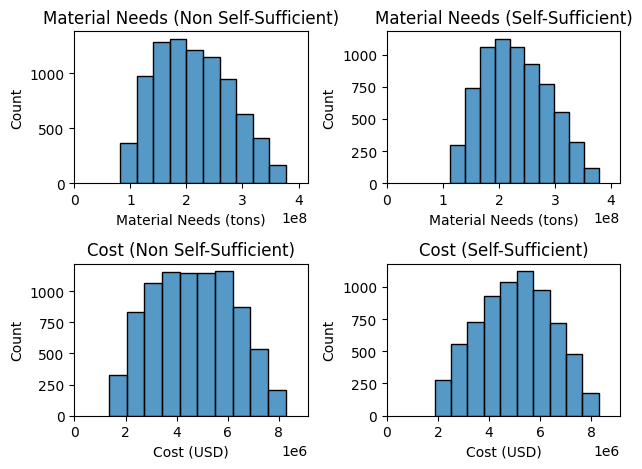

In [13]:
# plot a histogram of the material needs and costs of the whole dataset for both self-sufficiency scenarios
fig, ax = plt.subplots(1, 2)

ax_hist = sns.histplot(data=data_ss[data_ss['Feasibility']==True], x='Material Needs (tons)', bins=10, hue='Self-Sufficiency', ax=ax[0])
ax_hist.set_xlim(0, data_ss['Material Needs (tons)'].max()*1.1)
ax_hist.set_title('Material Needs Histogram')

ax_hist = sns.histplot(data=data_ss[data_ss['Feasibility']==True], x='Cost (USD)', bins=10, hue='Self-Sufficiency', ax=ax[1])
ax_hist.set_xlim(0, data_ss['Cost (USD)'].max()*1.1)
ax_hist.set_title('Cost Histogram')

plt.tight_layout()

# split the histograms into self-sufficient and non-self-sufficient for both material needs and costs
fig, ax = plt.subplots(2, 2)

data_ss_true = data_ss[(data_ss['Feasibility']==True) & (data_ss['Self-Sufficiency']==True)]
data_ss_false = data_ss[(data_ss['Feasibility']==True) & (data_ss['Self-Sufficiency']==False)]

ax_hist = sns.histplot(data=data_ss_false, x='Material Needs (tons)', bins=10, ax=ax[0, 0])
ax_hist.set_xlim(0, data_ss['Material Needs (tons)'].max()*1.1)
ax_hist.set_title('Material Needs (Non Self-Sufficient)')

ax_hist = sns.histplot(data=data_ss_true, x='Material Needs (tons)', bins=10, ax=ax[0, 1])
ax_hist.set_xlim(0, data_ss['Material Needs (tons)'].max()*1.1)
ax_hist.set_title('Material Needs (Self-Sufficient)')

ax_hist = sns.histplot(data=data_ss_false, x='Cost (USD)', bins=10, ax=ax[1, 0])
ax_hist.set_xlim(0, data_ss['Cost (USD)'].max()*1.1)
ax_hist.set_title('Cost (Non Self-Sufficient)')

ax_hist = sns.histplot(data=data_ss_true, x='Cost (USD)', bins=10, ax=ax[1, 1])
ax_hist.set_xlim(0, data_ss['Cost (USD)'].max()*1.1)
ax_hist.set_title('Cost (Self-Sufficient)')

plt.tight_layout()
plt.show()

### Step back

Phew okay this is getting a bit confusing. Let's take a step back and see what we have.

* **PointSS:** A class PointSS that generates points based on inputs of wind and solar quantities. Each "point" here is basically a representation of an energy system
* **data_ss** A dataframe of points with the following columns. Each of the rows of this dataframe is a representation of an energy system.
    - Wind Capacity (MW)
    - Solar Capacity (MW)
    - Cost (USD)
    - Material Needs (tons)
    - Feasibility
    - Self-Sufficiency
* **data_ss_min** A very small dataframe with just 2 points for two cost-minimal points, one self-sufficient and one not. The columns are as below. Note, there's no "Feasibility" column now.
    - Wind Capacity (MW)
    - Solar Capacity (MW)
    - Cost (USD)
    - Material Needs (tons)
    - Self-Sufficiency

That's basically it! Now we just need to find a way to communicate something interesting about the data.

Let's focus on the cost penalty of self-suffiency.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


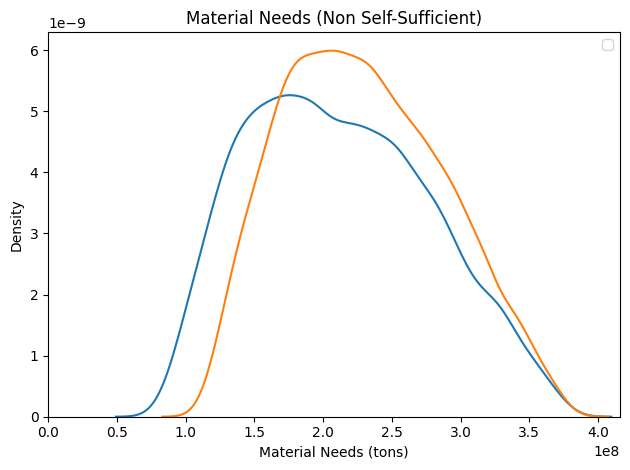

In [14]:
fig = plt.figure()

ax_kde = sns.kdeplot(data=data_ss_false, x='Material Needs (tons)')
ax_kde = sns.kdeplot(data=data_ss_true, x='Material Needs (tons)')

ax_kde.set_xlim(0, data_ss['Material Needs (tons)'].max()*1.1)
ax_kde.set_title('Material Needs (Non Self-Sufficient)')
ax_kde.legend()

plt.tight_layout()
plt.show()

Oh yeah, the distribution is a bit funky-looking because or the arbitrary points sampled. I should now limit the points to within 10% of the cost-optimum somehow.

## Limit points to 10% of Pareto front

The Pareto front in this simple example can be found analytically. Whereas in a real energy system model, some empirical method would need to be used.

The result from rearranging the equation is as follows.

$$
x_{x} = (1.4) \frac{D}{CF_{2}} - \frac{CF_{1}}{CF_{2}} x_{w}
$$



In [15]:
# threshold = 0.2 # 20% of Pareto Front

# # line equation
# m = - PointSS.CF[0] / PointSS.CF[1] # gradient
# b = 1.4 * PointSS.D / PointSS.CF[1] # intercept

# x_w_pf = np.linspace(0, x_wind_max, 64)
# x_s_pf = b + m * x_w_pf

# # filter points for within 10%
# data_ss['PF Solar Capacity (MW)'] = m * data_ss['Wind Capacity (MW)'] + b
# data_ss['diff'] = abs(data_ss['Solar Capacity (MW)'] - data_ss['PF Solar Capacity (MW)'])
# data_ss['threshold'] = threshold * abs(data_ss['PF Solar Capacity (MW)'])
# data_ss_thresh = data_ss[data_ss['diff'] <= data_ss['threshold']]

# # plot input space


# ax_2d_x_ss = sns.scatterplot(data=data_ss_thresh.loc[data_ss_thresh['Feasibility']==True], x='Wind Capacity (MW)', y='Solar Capacity (MW)', style='Feasibility', markers=['*', '^'], hue='Self-Sufficiency')
# ax_2d_x_ss.plot(sample_non_ss.x_wind, sample_non_ss.x_solar, marker='x', color='cyan', markersize=10, mew=4)
# ax_2d_x_ss.plot(sample_ss.x_wind, sample_ss.x_solar, marker='x', color='magenta', markersize=10, mew=4)
# ax_2d_x_ss.grid(True)
# plt.plot(x_w_pf, x_s_pf)
# plt.title('Input space: Wind and Solar Capacity')
# plt.show()

In [16]:
# fig = plt.figure()

# ax_kde = sns.kdeplot(data=data_ss_thresh[data_ss_thresh['Self-Sufficiency']==False], x='Material Needs (tons)')
# ax_kde = sns.kdeplot(data=data_ss_thresh[data_ss_thresh['Self-Sufficiency']==True], x='Material Needs (tons)')

# ax_kde.set_title('Material Needs (Non Self-Sufficient)')
# ax_kde.legend()

# plt.tight_layout()
# plt.show()

Still looks weird...

I need to filter to within x% of the pareto front for both the self-sufficient and non-self-sufficient case seperately.

Also the Pareto front needs to be on the output rather than the input.

### Find Pareto front

This section will focus on finding the Pareto front in the output space by algebraically manipulating the constraint equation to be in terms of $c$ and $m$.

$$
c = c_w x_w + c_s x_s, \\
m = m_w x_w + m_s x_s, \\
CF_w x_w + CF_s x_s = D
$$

Getting chatGPT to rearrange this as $m = f(c)$ gives the following.

$$
m = \frac{-m_{s} \cdot (CF_{w} \cdot c - D \cdot c_{w}) + m_{w} \cdot (CF_{s} \cdot c - D \cdot c_{s})}{CF_{s} \cdot c_{w} - CF_{w} \cdot c_{s}}
$$


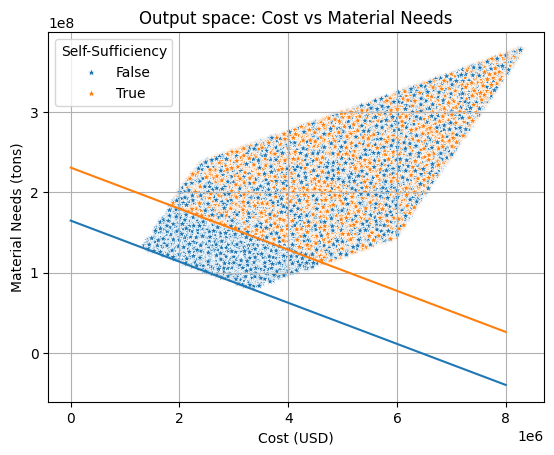

In [17]:
def m_pareto_front(cost, ss):
    if ss:
        return (
            -m_s * (cf_w * cost - D * 1.4 * c_w) + m_w * (cf_s * cost - D * 1.4 * c_s)
        ) / (cf_s * c_w - cf_w * c_s)
    else:
        return (-m_s * (cf_w * cost - D * c_w) + m_w * (cf_s * cost - D * c_s)) / (
            cf_s * c_w - cf_w * c_s
        )


# Equation of the straight line
c_pf = np.linspace(0, 8e6, 100)

m_pf_ss = m_pareto_front(c_pf, ss=True)
m_pf_nss = m_pareto_front(c_pf, ss=False)

# plot output space
ax = sns.scatterplot(data=data_ss.loc[data_ss['Feasibility']==True], x='Cost (USD)', y='Material Needs (tons)', hue='Self-Sufficiency', marker="*")
ax.plot(c_pf, m_pf_ss, color="tab:orange")
ax.plot(c_pf, m_pf_nss, color="tab:blue") 
ax.grid(True)
plt.title('Output space: Cost vs Material Needs')
plt.show()

### Filter points above PF

Using the equation of $m = f(c)$, we can filter out the points above the Pareto Front. The process is as follows:

For all points, $(c_0, m_0)$, do:
1. Project onto the Pareto Front to find $m_{PF} = f(c_0)$
1. If $m_0 > m_{PF}$, 
    the point is above the PF and should be removed. 
1. Else,
    the point is below the PF and should be retained.



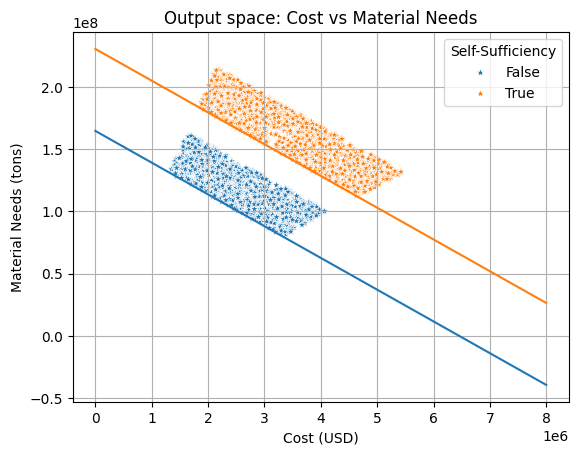

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


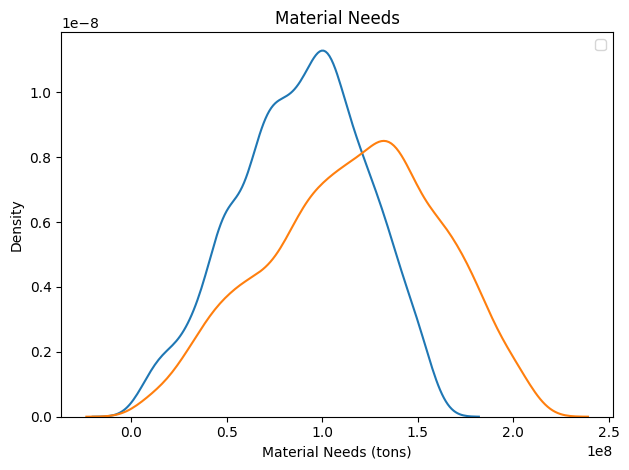

In [18]:
# project points onto both Pareto fronts
data_ss["Material Needs Pareto Front (tons)"] = np.nan
data_ss.loc[data_ss["Self-Sufficiency"] == True, "Material Needs Pareto Front (tons)"] = m_pareto_front(data_ss["Cost (USD)"], ss=True)
data_ss.loc[data_ss["Self-Sufficiency"] == False, "Material Needs Pareto Front (tons)"] = m_pareto_front(data_ss["Cost (USD)"], ss=False)

data_ss["Distance above PF"] = data_ss["Material Needs (tons)"] - data_ss["Material Needs Pareto Front (tons)"]

data_ss_filtered = data_ss.loc[data_ss["Distance above PF"] < 40000000]

# plot scatter diagrams for the filtered data
ax = sns.scatterplot(data=data_ss_filtered[data_ss_filtered["Feasibility"] == True] , x='Cost (USD)', y='Material Needs (tons)', hue='Self-Sufficiency', marker="*")
ax.plot(c_pf, m_pf_nss)
ax.plot(c_pf, m_pf_ss)
ax.grid(True)
plt.title('Output space: Cost vs Material Needs')
plt.show()

# plot KDE for each case
fig = plt.figure()
ax_kde = sns.kdeplot(data=data_ss_filtered[data_ss_filtered['Self-Sufficiency']==False], x='Material Needs (tons)')
ax_kde = sns.kdeplot(data=data_ss_filtered[data_ss_filtered['Self-Sufficiency']==True], x='Material Needs (tons)')
ax_kde.set_title('Material Needs')
ax_kde.legend()
plt.tight_layout()
plt.show()

### 2-D line distance (doesn't work)

To find the distance from each point $(x_{0}, y_{0}) \implies (c_{0}, m_{0})$ to the line, defined by $ax + by + c = 0 \implies a_{const}c + b_{const}m + c_{const} = 0$, use the formula below.

$$
d = \frac{|a x_{0} + b y_{0} + c|}{\sqrt{a^{2} + b^{2}}} \implies 
d = \frac{|a_{const} c_{0} + b_{const} m_{0} + c_{const}|}{\sqrt{a_{const}^{2} + b_{const}^{2}}} 
$$

The equation for the Pareto front can be rearranged into the form $ax + by + c = 0$.

$$
\underbrace{(-CF_{s}m_{w} + CF_{w}m_{s})}_{a}c + \underbrace{(CF_{s}c_{w} - CF_{w}c_{s})}_{b}m + \underbrace{D(-c_{s} m_{w} + c_{w} m_{s})}_{c} = 0
$$

ChatGPT's second attempt:
$$
\underbrace{(CF_{s}m_{w} + CF_{w}m_{s})}_{a}c + \underbrace{(-CF_{s}c_{w} + CF_{w}c_{s})}_{b}m + \underbrace{-D(c_{s} m_{w} + c_{w} m_{s})}_{c} = 0
$$


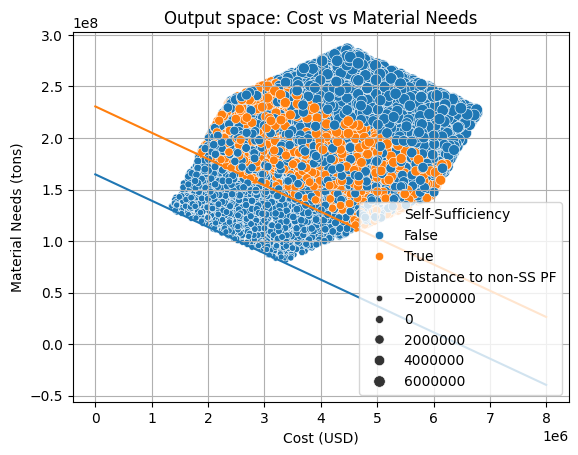

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


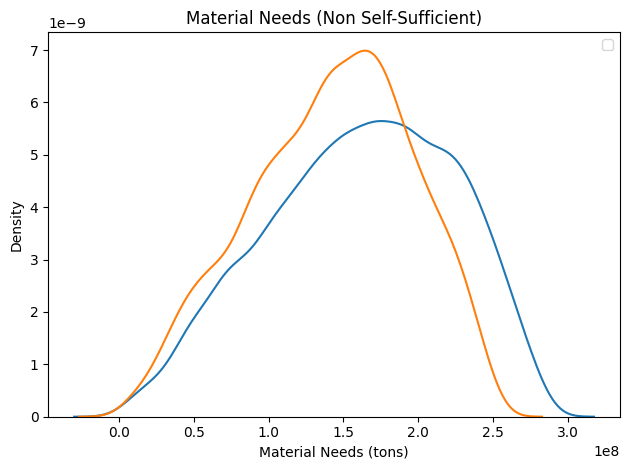

In [19]:
a_const = (cf_s * m_w - cf_w * m_s)
b_const = (-cf_s * c_w + cf_w * c_s)
c_const_ss = D * (-c_s * m_w + c_w * m_s)

c_const_nss = D * 1.4 * (-c_s * m_w + c_w * m_s)

def dist_to_PF(df, a, b, c):
    return (a * df["Cost (USD)"] + b * df["Material Needs (tons)"] + c) / (
        a**2 + b**2
    ) ** (1 / 2)

# encorporate the distance to the Pareto Front within the table of points (for self-sufficient and non-self-sufficient)
data_ss["Distance to SS PF"] = dist_to_PF(data_ss, a_const, b_const, c_const_ss)
data_ss["Distance to non-SS PF"] = dist_to_PF(data_ss, a_const, b_const, c_const_nss)

filter_distance = data_ss["Distance to SS PF"].max() * 0.4

# filter points to close to the PF and plot
data_ss_filtered = data_ss[(data_ss["Distance to SS PF"] <= filter_distance) | (data_ss["Self-Sufficiency"] == False)]
data_ss_filtered = data_ss_filtered[(data_ss_filtered["Distance to non-SS PF"] <= filter_distance) | (data_ss_filtered["Self-Sufficiency"] == True)]
# data_ss_filtered["Debug"] = False
# data_ss_filtered.at[4995, "Debug"] = True

ax = sns.scatterplot(data=data_ss_filtered[data_ss_filtered["Feasibility"] == True] , x='Cost (USD)', y='Material Needs (tons)', hue='Self-Sufficiency', markers='*', size="Distance to non-SS PF")
ax.plot(c_pf, m_pf_nss)
ax.plot(c_pf, m_pf_ss)
ax.grid(True)
plt.title('Output space: Cost vs Material Needs')
plt.show()

# plot KDE for each case
fig = plt.figure()
ax_kde = sns.kdeplot(data=data_ss_filtered[data_ss_filtered['Self-Sufficiency']==False], x='Material Needs (tons)')
ax_kde = sns.kdeplot(data=data_ss_filtered[data_ss_filtered['Self-Sufficiency']==True], x='Material Needs (tons)')
ax_kde.set_title('Material Needs (Non Self-Sufficient)')
ax_kde.legend()
plt.tight_layout()
plt.show()

Want to show material cost penalty of self-sufficiency

Kernal density estimation for each self-sufficiency case. (seaborn kde plot)

Epistemologic research question
x = method used: [just two points, lots of points]
y = depth of conclusions

To measure depth of conclusions
x = self sufficiency
y = [material needs, cost]

* what can we say about self-sufficiency that we can't do with 2 cost-minimal points?

Research question:
* what is the trade-off between self-suffiency and [cost, material needs] of an energy system?

What do people care about?
* mix: wind, solar
* cost, materials
* self-sufficiency



## Repeat but for samples within 10% of the pareto-front

I don't know if this is really much better than the SPORES approach. I feel like other applications of surrogate models are more of an advance:
* uncertainty
* multi-parameter optimisation

What we are doing is kinda both already.

To do next
* Repeat for points along the Pareto front (and/or within 10% of PF)
* Find the trade-offs
* do a final comparison of left=just 2 cost-optimal points, right=all samples for
    1. trade-offs (i.e., gradient of pareto front)
    2. trade-offs 2 (i.e., the self-sufficienct vs non-self-sufficient plots for economic and material cost)

Outcome of this discussion with Tim was unclear. Basically we need some way of showing outputs that clearly shows the richer outcomes for having more data points. Consider what people are interested in knowing - e.g., could be ratio of wind to solar or something.

In [20]:
# filter the data for feasible points within 10% of the pareto front



# References
1. https://www.eia.gov/todayinenergy/detail.php?id=54519 
1. https://cleantechnica.com/2023/03/27/how-much-steel-will-all-those-wind-turbines-solar-panels-need-can-we-make-it/#:~:text=Each%20new%20MW%20of%20solar,to%20180%20tons%20of%20steel
1. https://www.nrel.gov/docs/fy15osti/63038.pdf
1. Tim et al. https://www.sciencedirect.com/science/article/pii/S2542435120303366